<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">IMPORTING LIBRARIES</p>

In [1]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

<a id="2"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">LOADING DATA</p>

In [3]:
#Loading the dataset
data = pd.read_csv("/content/marketing_campaign.csv")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [4]:
#Information on features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))


In [6]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [7]:
# Convert 'Dt_Customer' to a datetime object with the correct format
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], dayfirst=True)

# Calculate the difference in days from the latest date
d1 = data['Dt_Customer'].max()  # Newest customer date
days = [(d1 - date).days for date in data['Dt_Customer']]  # Difference in days

# Create the 'Customer_For' feature
data['Customer_For'] = pd.to_numeric(days, errors='coerce')


In [8]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


**In the next bit, I will be performing the following steps to engineer some new features:**

* Extract the **"Age"** of a customer by the **"Year_Birth"** indicating the birth year of the respective person.
* Create another feature **"Spent"** indicating the total amount spent by the customer in various categories over the span of two years.
* Create another feature **"Living_With"** out of **"Marital_Status"** to extract the living situation of couples.
* Create a feature **"Children"** to indicate total children in a household that is, kids and teenagers.
* To get further clarity of household, Creating feature indicating **"Family_Size"**
* Create a feature **"Is_Parent"** to indicate parenthood status
* Lastly, I will create three categories in the **"Education"** by simplifying its value counts.
* Dropping some of the redundant features

In [9]:
#Feature Engineering
#Age of customer today
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

<ipython-input-9-7ccaa6536fcb>:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]


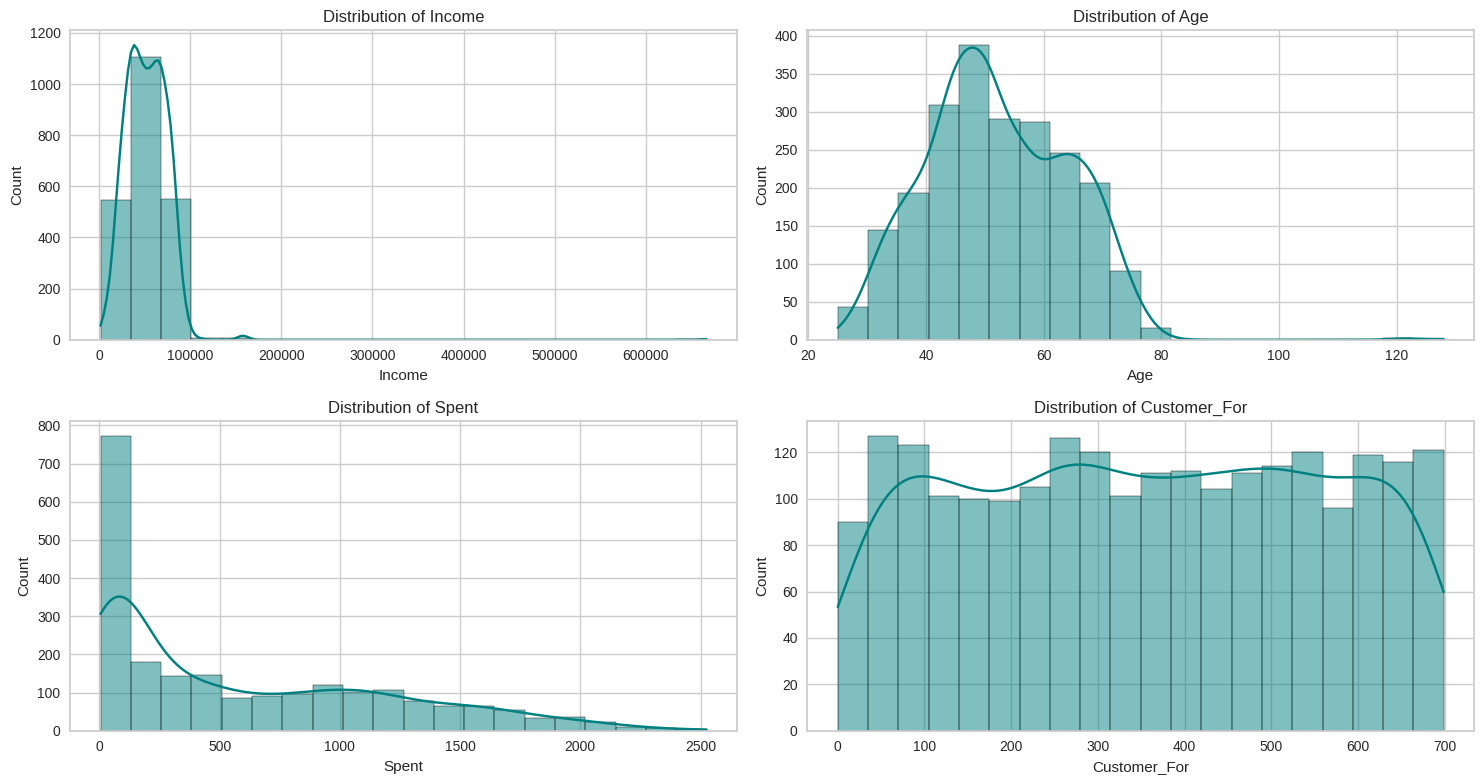

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting distributions of key numerical features
plt.figure(figsize=(15, 8))
for i, column in enumerate(['Income', 'Age', 'Spent', 'Customer_For']):
    plt.subplot(2, 2, i+1)
    sns.histplot(data[column], kde=True, bins=20, color='teal')
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

Income: Right-skewed distribution, indicating most customers have moderate income, with fewer high-income individuals.

Age: Bimodal distribution with peaks around 30-40 and 50-60 years, suggesting two distinct age groups.

Spent: Heavily right-skewed, showing a majority of customers with low spending, and only a few high spenders.

Customer_For: Fairly uniform distribution, suggesting a balanced mix of both new and long-term customers.

Now that we have some new features let's have a look at the data's stats.

In [11]:
data.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354     0.441787     0.505415    49.012635   305.091606   
std     25173.076661     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  ...   
mean     26.356047   166.995939    37.637635    27.028881    43.965253  ...   
std      39.793917   224.283273    54.752082    41.072046    51.815414  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    68.000000    12.000000     8.000000    24.500000  ...   
75%      33.000000   232.250000    50.000000    33.000000    56.000000  ...   
max     199.000000  1725.000000   259.000000   262.000000   321.000000  ...   

       AcceptedCmp1  AcceptedCmp2     Complain     Response  Customer_For  \
count   2216.000000   2216.000000  2216.000000  2216.000000   2216.000000   
mean       0.064079      0.013538     0.009477     0.150271    353.521209   
std        0.244950      0.115588     0.096907     0.357417    202.434667   
min        0.000000      0.000000     0.000000     0.000000      0.000000   
25%        0.000000      0.000000     0.000000     0.000000    180.000000   
50%        0.000000      0.000000     0.000000     0.000000    355.500000   
75%        0.000000      0.000000     0.000000     0.000000    529.000000   
max        1.000000      1.000000     1.000000     1.000000    699.000000   

               Age        Spent     Children  Family_Size    Is_Parent  
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  
mean     52.179603   607.075361     0.947202     2.592509     0.714350  
std      11.985554   602.900476     0.749062     0.905722     0.451825  
min      25.000000     5.000000     0.000000     1.000000     0.000000  
25%      44.000000    69.000000     0.000000     2.000000     0.000000  
50%      51.000000   396.500000     1.000000     3.000000     1.000000  
75%      62.000000  1048.000000     1.000000     3.000000     1.000000  
max     128.000000  2525.000000     3.000000     5.000000     1.000000  

[8 rows x 28 columns]

The above stats show some discrepancies in mean Income and Age and max Income and age.

Do note that  max-age is 128 years, As I calculated the age that would be today (i.e. 2021) and the data is old.

I must take a look at the broader view of the data.
I will plot some of the selected features.

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

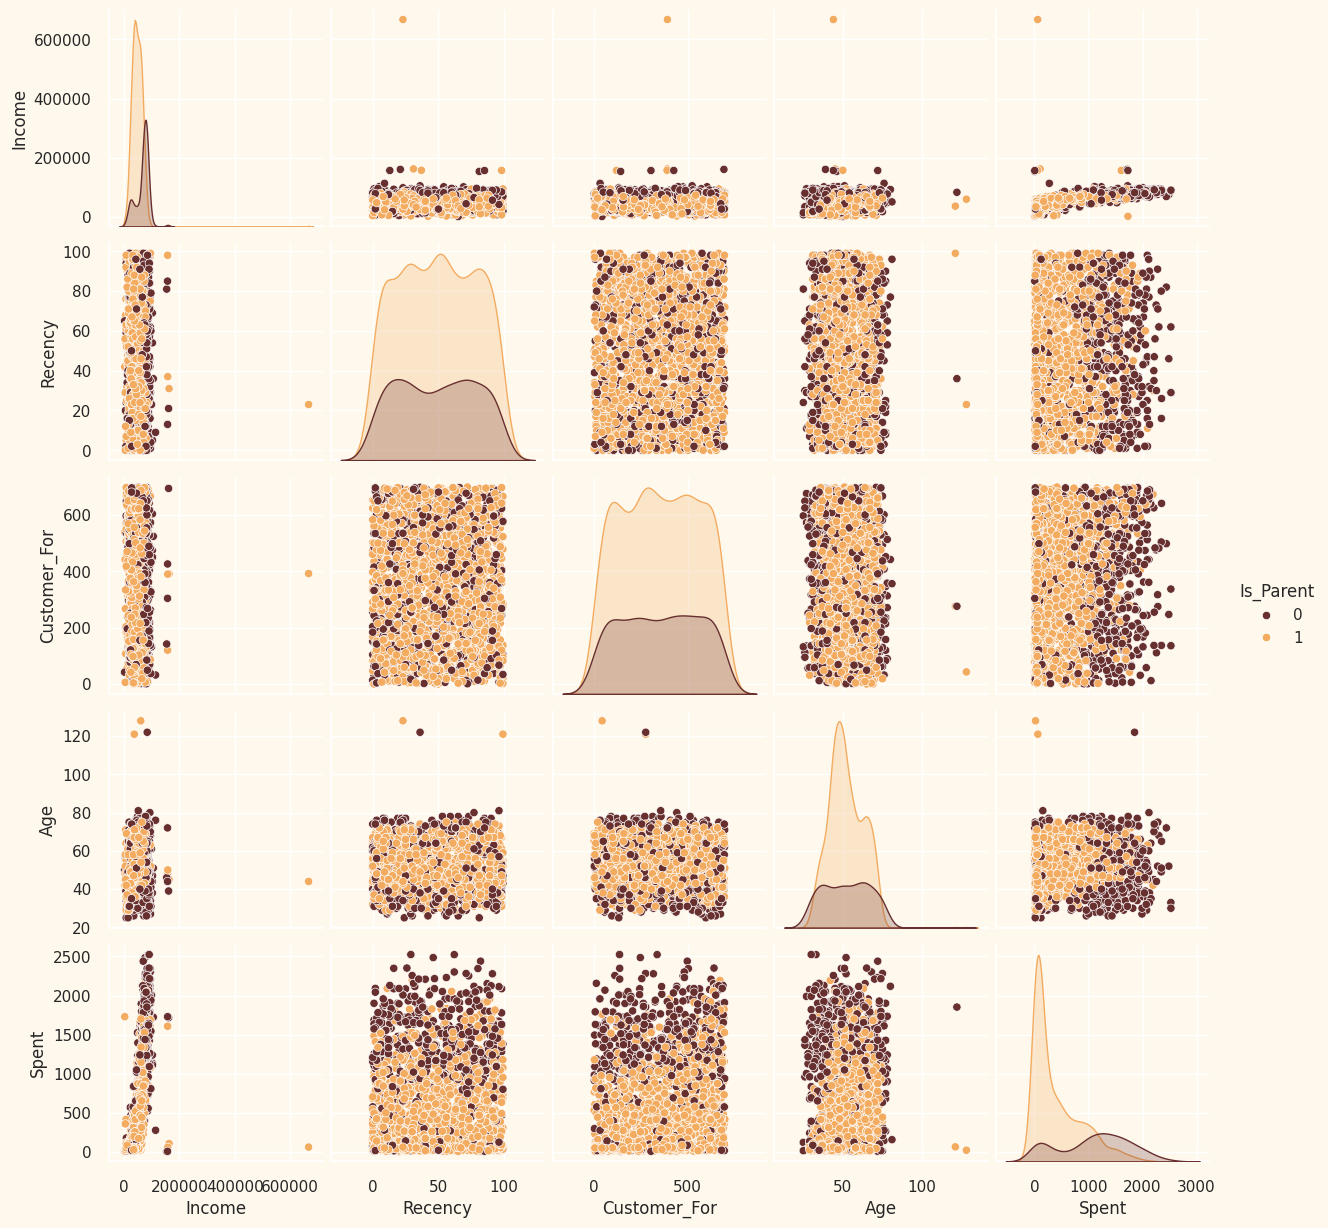

In [12]:
#To plot some selected features
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue
plt.show()

Clearly, there are a few outliers in the Income and Age features.
I will be deleting the outliers in the data.

In [13]:
# #Dropping the outliers by setting a cap on Age and income.
# data = data[(data["Age"]<90)]
# data = data[(data["Income"]<600000)]
# print("The total number of data-points after removing the outliers are:", len(data))


# Outlier Detection Function
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Removing outliers from 'Age', 'Income', and 'Spent'
data = remove_outliers(data, 'Age')
data = remove_outliers(data, 'Income')
data = remove_outliers(data, 'Spent')

print(f"Data size after outlier removal: {data.shape}")


Data size after outlier removal: (2202, 30)


Next, let us look at the correlation amongst the features.
(Excluding the categorical attributes at this point)

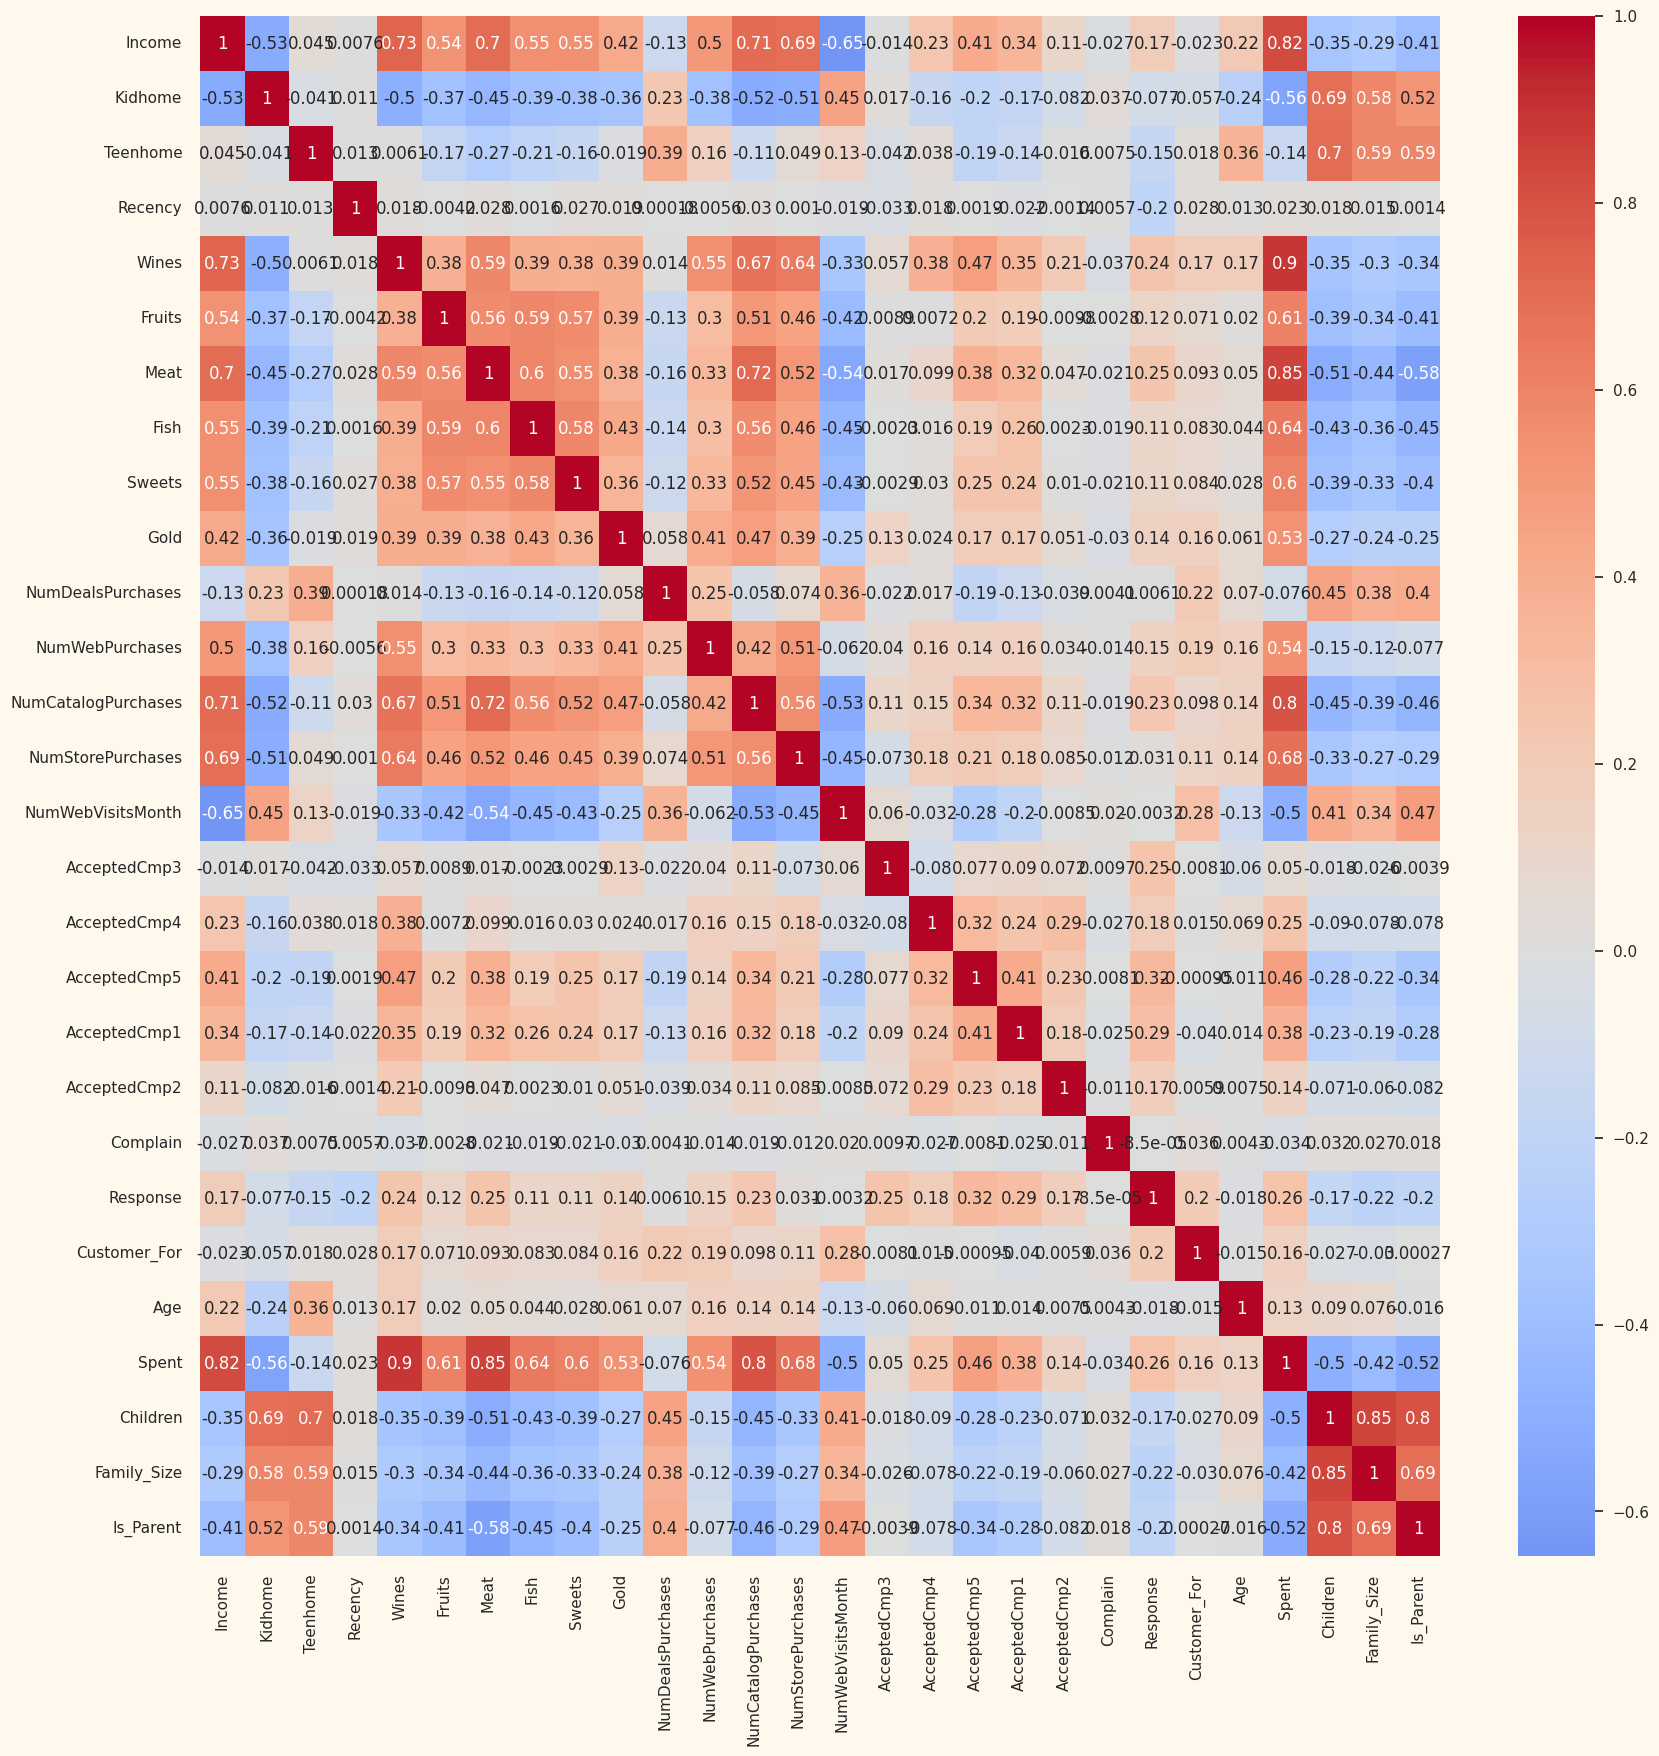

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_data = data.select_dtypes(include='number')

# Calculate the correlation matrix
corrmat = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, annot=True, cmap='coolwarm', center=0)
plt.show()


The data is quite clean and the new features have been included. I will proceed to the next step. That is, preprocessing the data.

<a id="4"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DATA PREPROCESSING</p>

In this section, I will be preprocessing the data to perform clustering operations.

**The following steps are applied to preprocess the data:**

* Label encoding the categorical features
* Scaling the features using the standard scaler
* Creating a subset dataframe for dimensionality reduction

In [15]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [16]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


#### Scaling

In [17]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [18]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0  -0.891910  0.317669 -0.824347 -0.931951  0.310276  0.982089  1.560050   
1  -0.891910 -0.252786  1.037409  0.905252 -0.380865 -0.874727 -0.637988   
2  -0.891910  0.969430 -0.824347 -0.931951 -0.795550  0.360174  0.574723   
3  -0.891910 -1.205543  1.037409 -0.931951 -0.795550 -0.874727 -0.562193   
4   0.571567  0.325166  1.037409 -0.931951  1.554331 -0.392669  0.423134   

       Meat      Fish    Sweets  ...  NumCatalogPurchases  NumStorePurchases  \
0  1.764807  2.450732  1.491629  ...             2.634148          -0.561148   
1 -0.732143 -0.650963 -0.634637  ...            -0.587100          -1.178508   
2 -0.172641  1.337771 -0.145840  ...            -0.229184           1.290934   
3 -0.667407 -0.505001 -0.585757  ...            -0.945016          -0.561148   
4 -0.214257  0.151828  0.000799  ...             0.128733           0.056213   

   NumWebVisitsMonth  Customer_For       Age     Spent  Living_With  Children  \
0           0.687909      1.525934  1.016304  1.694294    -1.348874 -1.268839   
1          -0.141650     -1.189459  1.273043 -0.965610    -1.348874  1.402274   
2          -0.556430     -0.206981  0.331669  0.287389     0.741359 -1.268839   
3           0.273129     -1.061095 -1.294340 -0.922115     0.741359  0.066717   
4          -0.141650     -0.952479 -1.037602 -0.304816     0.741359  0.066717   

   Family_Size  Is_Parent  
0    -1.762359  -1.588458  
1     0.446986   0.629541  
2    -0.657686  -1.588458  
3     0.446986   0.629541  
4     0.446986   0.629541  

[5 rows x 23 columns]

<a id="5"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DIMENSIONALITY REDUCTION</p>
In this problem, there are many factors on the basis of which the final classification will be done. These factors are basically attributes or features. The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. This is why I will be performing dimensionality reduction on the selected features before putting them through a classifier.  
*Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.*

**Principal component analysis (PCA)** is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

**Steps in this section:**
* Dimensionality reduction with PCA
* Plotting the reduced dataframe

**Dimensionality reduction with PCA**

For this project, I will be reducing the dimensions to 3.

In [19]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2202.0 -9.035057e-17  2.899909 -6.051007 -2.565695 -0.780613  2.428140   
col2  2202.0  1.290722e-17  1.716922 -4.201046 -1.333776 -0.171528  1.239008   
col3  2202.0  5.001550e-17  1.232294 -3.642657 -0.859315 -0.057169  0.859035   

           max  
col1  7.550268  
col2  6.197245  
col3  6.889508

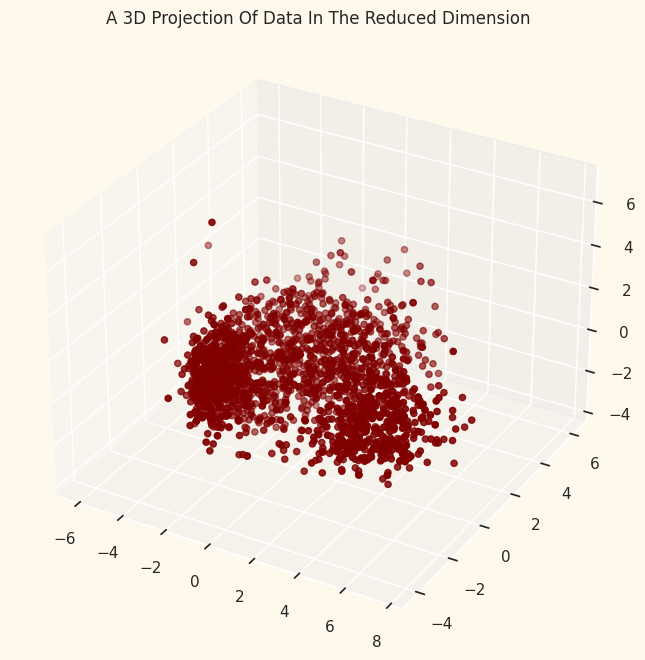

In [20]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

<a id="6"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">CLUSTERING</p>

Now that I have reduced the attributes to three dimensions, I will be performing clustering via Agglomerative clustering. Agglomerative clustering is a hierarchical clustering method.  It involves merging examples until the desired number of clusters is achieved.

**Steps involved in the Clustering**
* Elbow Method to determine the number of clusters to be formed
* Clustering via Agglomerative Clustering
* Examining the clusters formed via scatter plot

Elbow Method to determine the number of clusters to be formed:


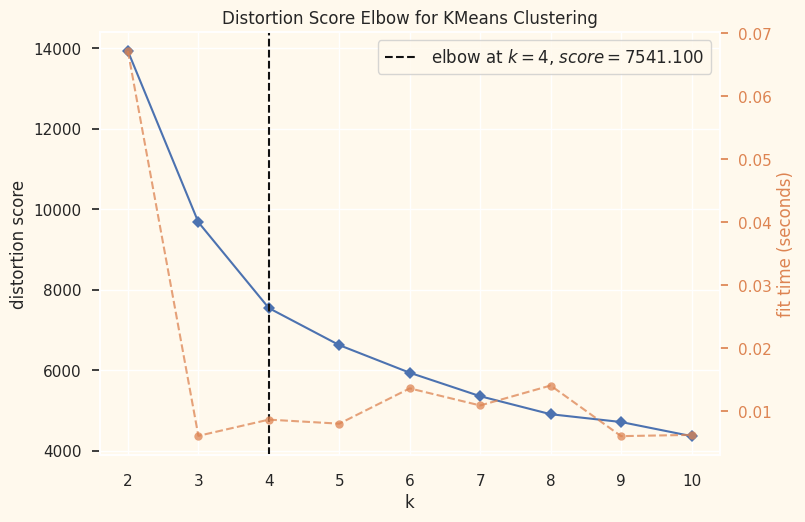

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

The above cell indicates that four will be an optimal number of clusters for this data.
Next, we will be fitting the Agglomerative Clustering Model to get the final clusters.

In [22]:
#Initiating the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

To examine the clusters formed let's have a look at the 3-D distribution of the clusters.

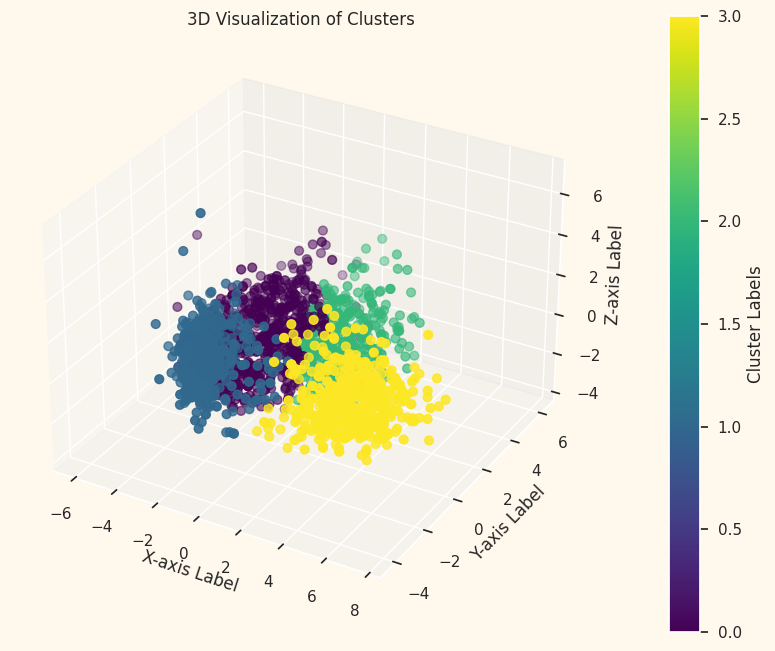

In [23]:
from mpl_toolkits.mplot3d import Axes3D
# Example 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Customize colors using Seaborn for better visualization
scatter = ax.scatter(x, y, z, c=PCA_ds["Clusters"], cmap='viridis', s=40)

# Add color bar to the plot for reference
color_bar = plt.colorbar(scatter, ax=ax, pad=0.1)
color_bar.set_label("Cluster Labels")

# Setting titles and labels
ax.set_title("3D Visualization of Clusters")
ax.set_xlabel("X-axis Label")
ax.set_ylabel("Y-axis Label")
ax.set_zlabel("Z-axis Label")

plt.show()


<a id="7"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">EVALUATING MODELS</p>

Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model. The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

**Firstly, let us have a look at the group distribution of clustring**

<ipython-input-28-2978675823d6>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data["Clusters"], palette=pal, ax=ax)


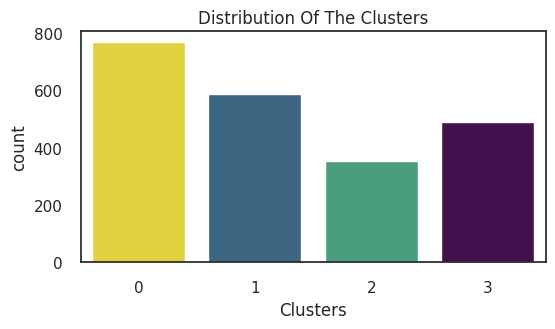

In [28]:
# Define your color palette
pal = ["#fbe525", "#31688e", "#3cac7e", "#490858"]

# Set the plot style and create a figure with a specific background color
sns.set_style("white")
fig, ax = plt.subplots(figsize=(6, 3))
#fig.patch.set_facecolor('#f7f2e6')  # Set the figure background color (outer area)

# Plot the count plot
pl = sns.countplot(x=data["Clusters"], palette=pal, ax=ax)
pl.set_title("Distribution Of The Clusters")
plt.savefig('clusters.png', format='png', dpi=300)
# Display the plot
plt.show()


The clusters seem to be fairly distributed.

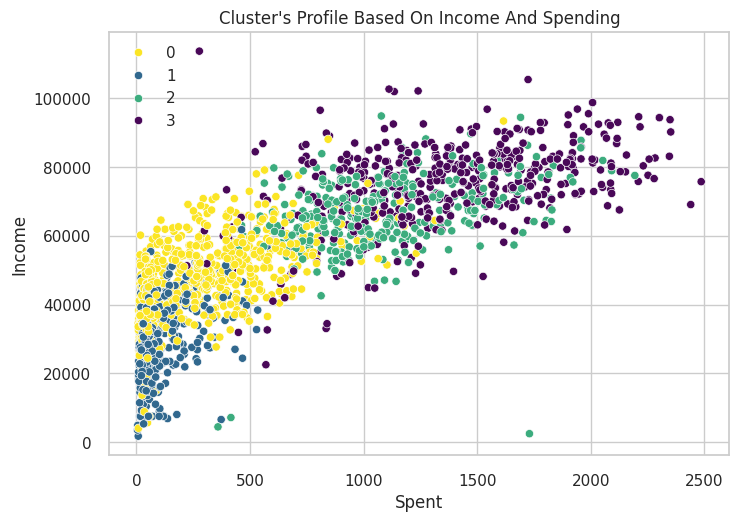

In [30]:
sns.set_style("whitegrid")
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.savefig('scatterPlot.png', format='png', dpi=300)
plt.show()

**Income vs  spending plot shows the clusters pattern**
* group 0: high spending & average income
* group 1: high spending & high income
* group 2: low spending & low income
* group 3: high spending & low income  

Next, I will be looking at the detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 50.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 71.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-31-9c5393e5930c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 56.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/ca

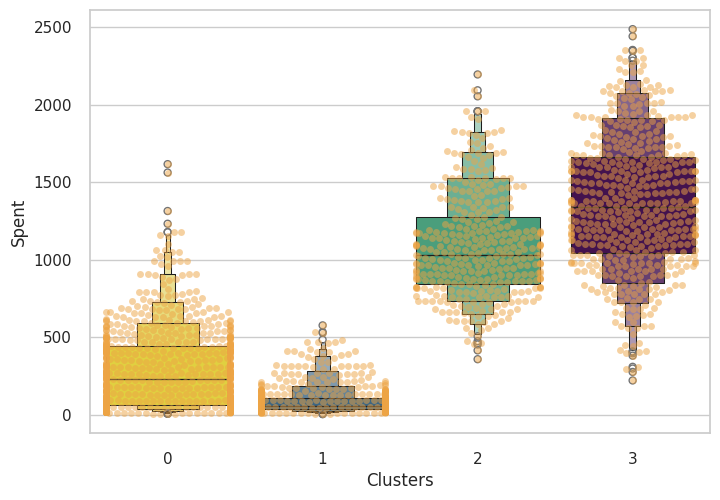

In [31]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#eda445", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.savefig('swarm_box_plot.png', format='png', dpi=300)
plt.show()


From the above plot, it can be clearly seen that cluster 2 is our biggest set of customers closely followed by cluster 0.
We can explore what each cluster is spending on for the targeted marketing strategies.


Let us next explore how did our campaigns do in the past.

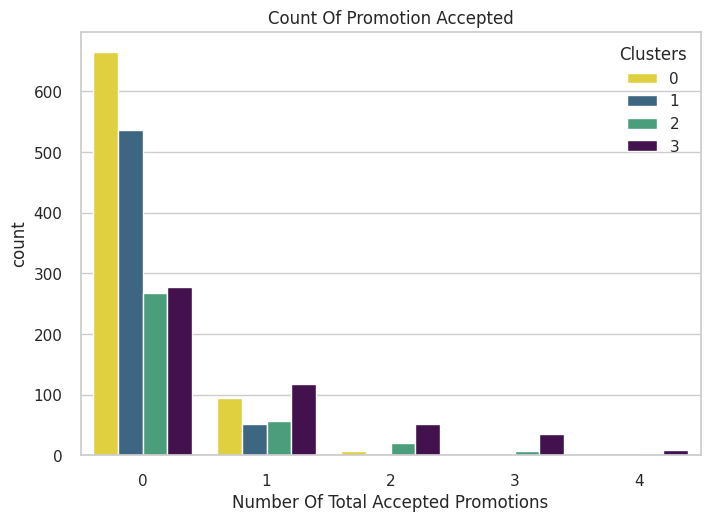

In [32]:
#Creating a feature to get a sum of accepted promotions
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.savefig('acceptedcmp.png', format='png', dpi=300)
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.


<ipython-input-33-cda471f0d22b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)


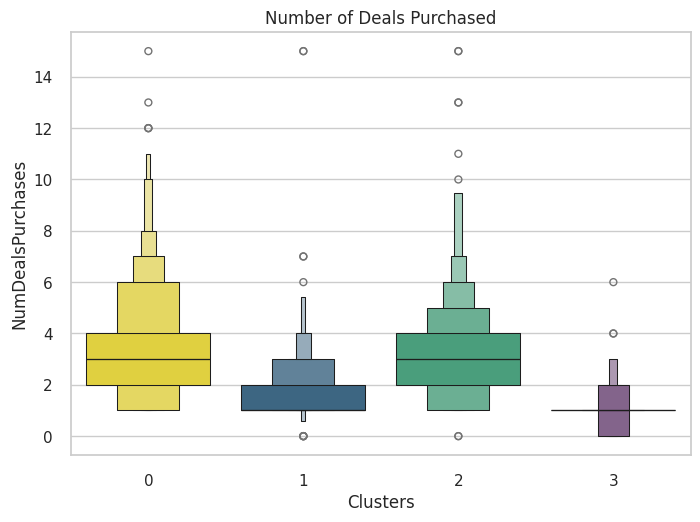

In [33]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.savefig('deals.png', format='png', dpi=300)
plt.show()

Unlike campaigns, the deals offered did well. It has best outcome with cluster 0 and cluster 3.
However, our star customers cluster 1 are not much into the deals.
Nothing seems to attract cluster 2 overwhelmingly


<Figure size 800x550 with 0 Axes>

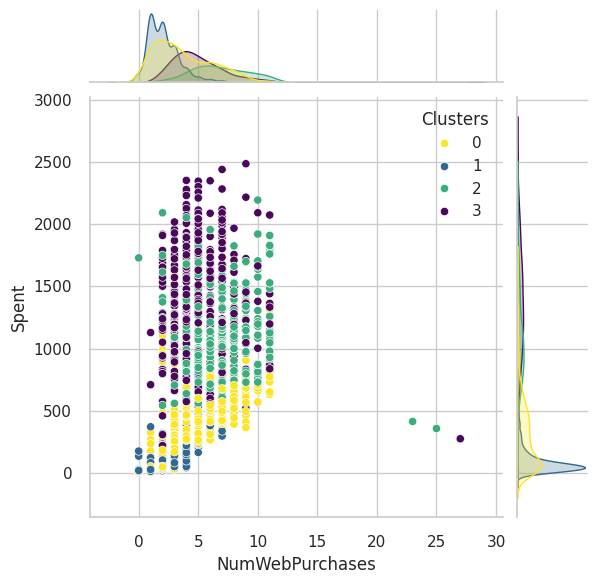

<Figure size 800x550 with 0 Axes>

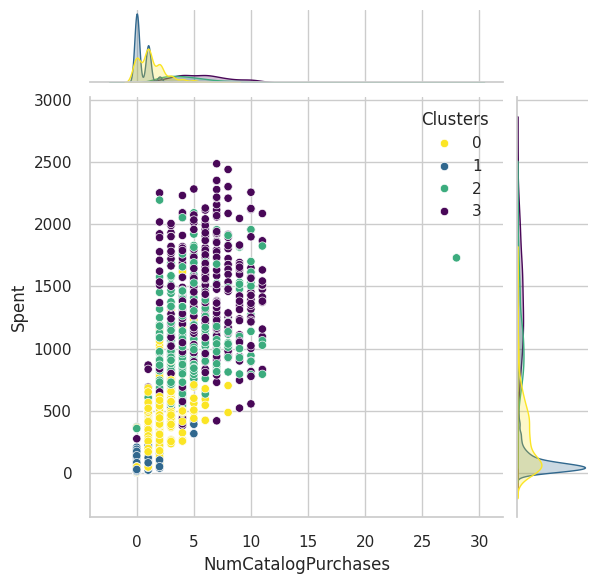

<Figure size 800x550 with 0 Axes>

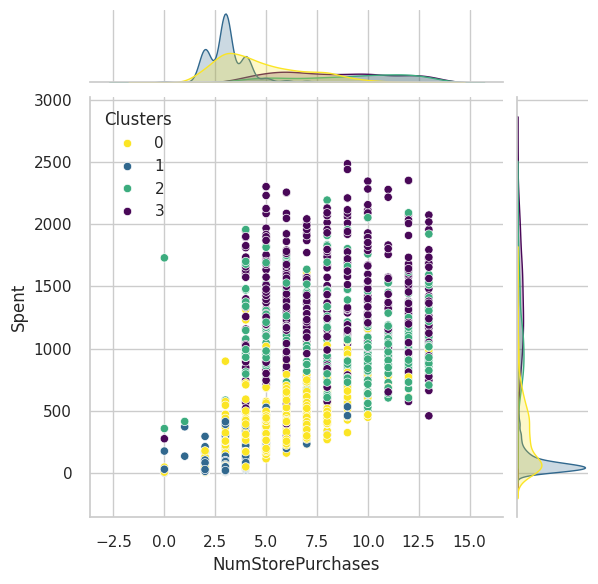

<Figure size 800x550 with 0 Axes>

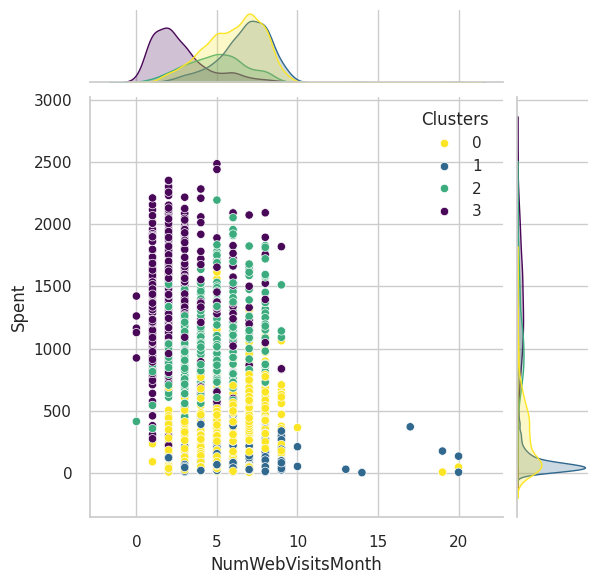

In [34]:
#for more details on the purchasing style
Places =["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",  "NumWebVisitsMonth"]

for i in Places:
    plt.figure()
    sns.jointplot(x=data[i],y = data["Spent"],hue=data["Clusters"], palette= pal)
    plt.savefig(f'jointplot_{i}.png', format='png', dpi=300)
    plt.show()

<a id="8"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">PROFILING</p>

Now that we have formed the clusters and looked at their purchasing habits.
Let us see who all are there in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that I will be plotting some of the features that are indicative of the customer's personal traits in light of the cluster they are in.
On the basis of the outcomes, I will be arriving at the conclusions.

<Figure size 800x550 with 0 Axes>

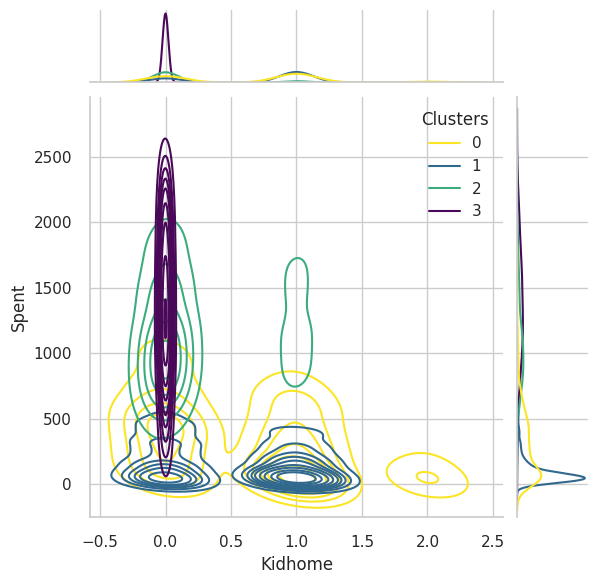

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

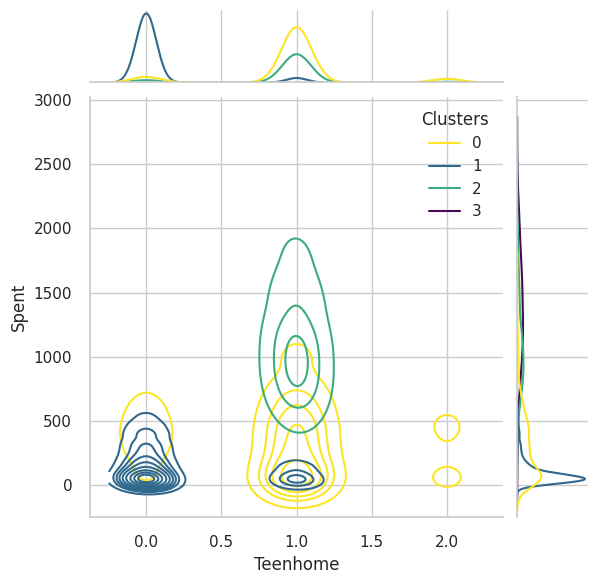

<Figure size 800x550 with 0 Axes>

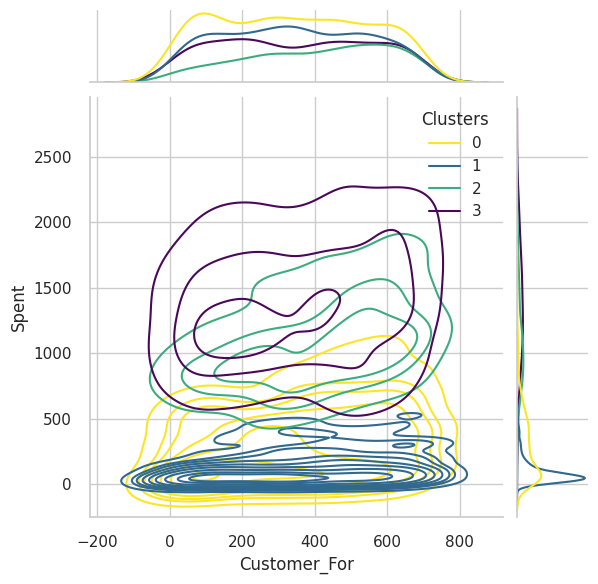

<Figure size 800x550 with 0 Axes>

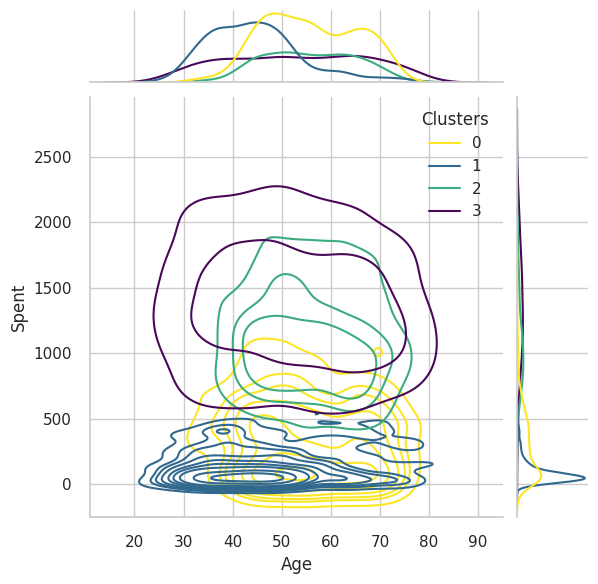

<Figure size 800x550 with 0 Axes>

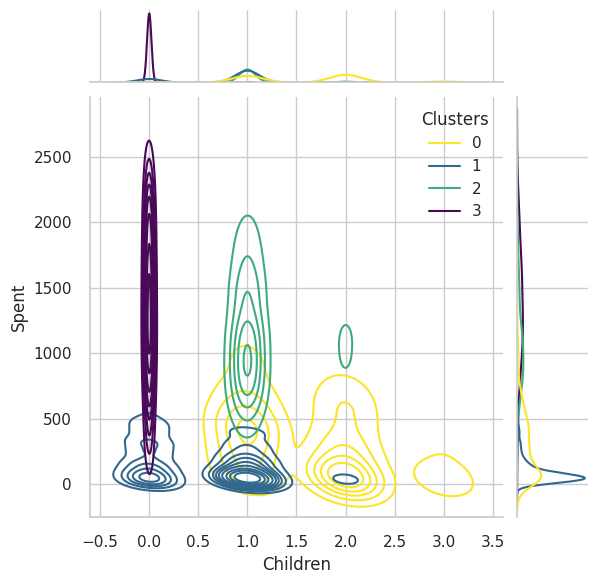

<Figure size 800x550 with 0 Axes>

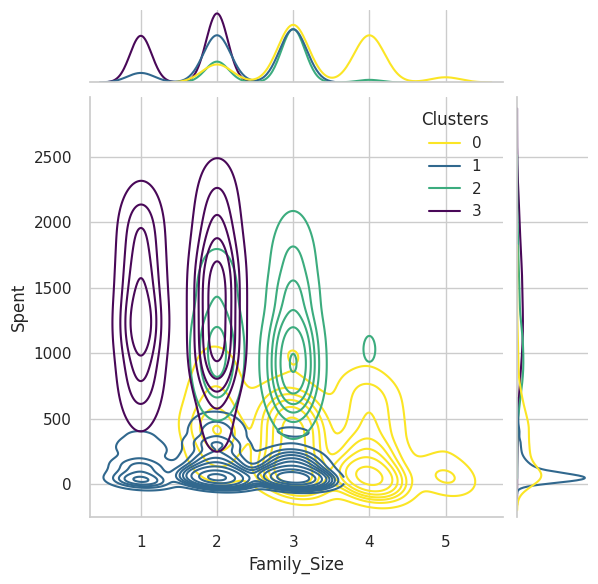

<Figure size 800x550 with 0 Axes>

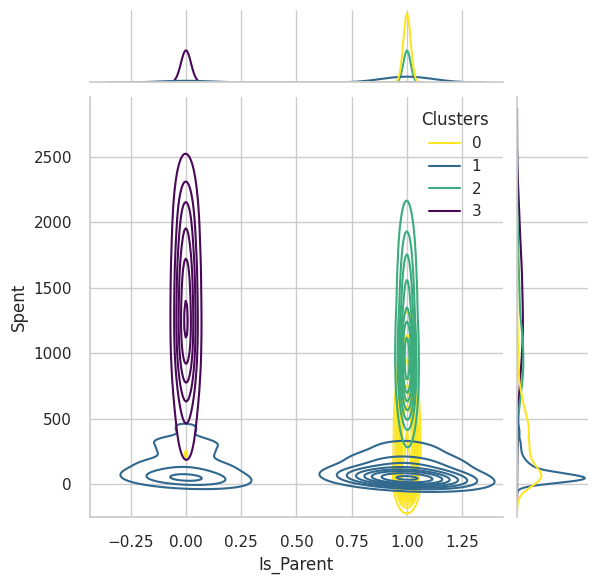

<Figure size 800x550 with 0 Axes>

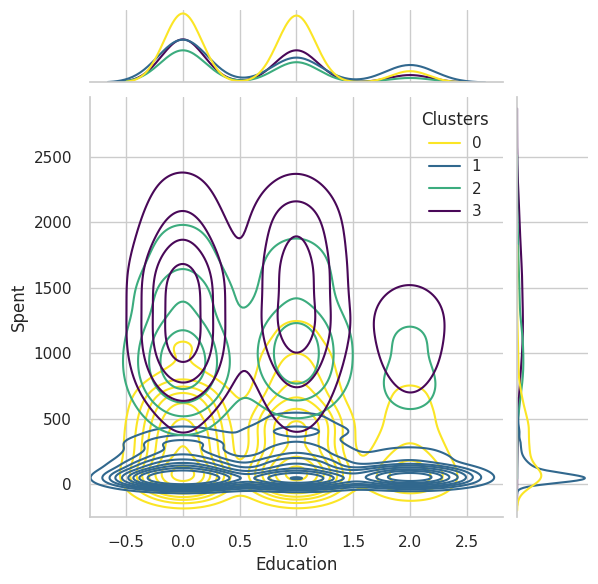

<Figure size 800x550 with 0 Axes>

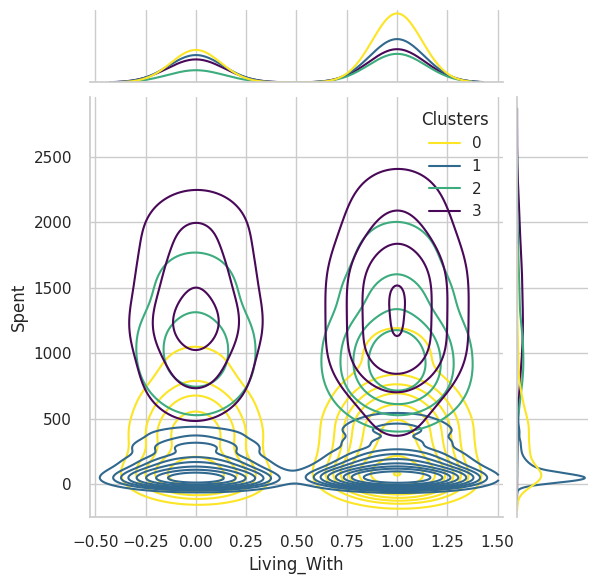

In [35]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    #plt.savefig(f'jointplot_{i}.png', format='png', dpi=300)
    plt.show()


# Similarity/Dissimilarity Measures

In [ ]:
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

# Standardizing the dataset for distance calculations
scaled_data = StandardScaler().fit_transform(data.select_dtypes(include=[np.number]))

# Calculating Euclidean distance matrix
euclidean_dist = pdist(scaled_data, metric='euclidean')
euclidean_dist_matrix = squareform(euclidean_dist)  # Convert to square form for easy viewing

# Calculating Cosine similarity matrix
cosine_sim_matrix = cosine_similarity(scaled_data)

# Displaying the Euclidean and Cosine similarity matrices
print("Euclidean Distance Matrix:")
print(euclidean_dist_matrix)

print("\nCosine Similarity Matrix:")
print(cosine_sim_matrix)


Euclidean Distance Matrix:
[[ 0.         10.15370279  6.68138496 ...  8.50382883  7.83935781
   9.55999811]
 [10.15370279  0.          7.58406127 ...  9.10687691  6.15040066
   4.91134984]
 [ 6.68138496  7.58406127  0.         ...  6.46947608  4.33864957
   7.88671503]
 ...
 [ 8.50382883  9.10687691  6.46947608 ...  0.          7.84570198
  10.12435458]
 [ 7.83935781  6.15040066  4.33864957 ...  7.84570198  0.
   6.37041255]
 [ 9.55999811  4.91134984  7.88671503 ... 10.12435458  6.37041255
   0.        ]]

Cosine Similarity Matrix:
[[ 1.         -0.51029583  0.41534054 ...  0.23609487  0.07595938
  -0.25626114]
 [-0.51029583  1.         -0.49939975 ... -0.36081644 -0.14240731
   0.42166152]
 [ 0.41534054 -0.49939975  1.         ...  0.35192644  0.43468945
  -0.50253489]
 ...
 [ 0.23609487 -0.36081644  0.35192644 ...  1.         -0.09729362
  -0.60124272]
 [ 0.07595938 -0.14240731  0.43468945 ... -0.09729362  1.
  -0.12303112]
 [-0.25626114  0.42166152 -0.50253489 ... -0.60124272 -0.123

In [ ]:
cluster_labels = yhat_AC
# Then proceed with the code for intra-cluster and inter-cluster distances
intra_distances, inter_distances = [], []

for cluster in np.unique(cluster_labels):
    # Points in the current cluster
    cluster_points = scaled_data[cluster_labels == cluster]

    # Intra-cluster distances (within the same cluster)
    intra_cluster_distances = pairwise_distances(cluster_points, metric='euclidean')
    intra_distances.append(intra_cluster_distances.mean())

    # Inter-cluster distances (between different clusters)
    other_points = scaled_data[cluster_labels != cluster]
    inter_cluster_distances = pairwise_distances(cluster_points, other_points, metric='euclidean')
    inter_distances.append(inter_cluster_distances.mean())

print("Average Intra-cluster Distance:", np.mean(intra_distances))
print("Average Inter-cluster Distance:", np.mean(inter_distances))


Average Intra-cluster Distance: 6.263213199153256
Average Inter-cluster Distance: 8.229446699627276


1. Since the inter-cluster distance (8.30) is higher than the intra-cluster distance (6.26), this is a good sign that the clusters formed by your Agglomerative Clustering model are distinct from each other, with relatively cohesive grouping within clusters.
2. The gap between intra- and inter-cluster distances is also relevant. Larger gaps indicate more distinct clustering. In this case, there’s a moderate gap, which suggests reasonably well-separated clusters, but there could be room for optimization if required.

In [ ]:
cluster_cosine_sim = []

for cluster in np.unique(cluster_labels):
    cluster_points = scaled_data[cluster_labels == cluster]
    sim_matrix = cosine_similarity(cluster_points)

    # Removing diagonal and duplicate entries
    cluster_sim_flat = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    cluster_cosine_sim.append(cluster_sim_flat.mean())

print("Average Cosine Similarity within each Cluster:")
for i, sim in enumerate(cluster_cosine_sim):
    print(f"Cluster {i}: {sim}")


Average Cosine Similarity within each Cluster:
Cluster 0: 0.3001421908443696
Cluster 1: 0.4298392860970552
Cluster 2: 0.2877551887118949
Cluster 3: 0.44391531443574445


The average cosine similarity within each cluster reflects the degree of similarity between points in that cluster, providing insight into the cohesion of the clustered data.

1. Cluster 0: The average cosine similarity is 0.300, indicating relatively low similarity among its members, suggesting that this cluster may contain diverse or less-related items.

2. Cluster 1: With an average similarity of 0.4298, this cluster shows a moderate level of similarity, implying that the points are somewhat more closely related compared to Cluster 0.

3. Cluster 2: The average similarity of 0.2877 suggests a similar level of cohesion as Cluster 1, indicating that the members are relatively similar but not as tightly grouped as in Cluster 3.

4. |Cluster 3: This cluster exhibits the highest average cosine similarity at 0.4439, suggesting a stronger relationship among its points. This may indicate that the items in this cluster share more characteristics or features.

In [40]:
data.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2202, 32)

## Association Mining Rule over Products

In [37]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
# Select only the product-related columns with correct names
product_columns = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']

# Create a function to convert amounts to binary (bought/not bought)
def convert_to_binary(x):
    return 1 if x > 0 else 0

# Create binary columns for each product
df_binary = data[product_columns].applymap(convert_to_binary)

# Generate frequent itemsets using Apriori algorithm
# min_support=0.1 means the itemset must appear in at least 10% of transactions
frequent_itemsets = apriori(df_binary,
                          min_support=0.1,
                          use_colnames=True)

# Generate association rules
# min_threshold=0.5 means we want rules with at least 50% confidence
rules = association_rules(frequent_itemsets,metric="confidence",min_threshold=0.5,num_itemsets=10)

# Sort rules by lift (measure of rule strength)
rules = rules.sort_values('lift', ascending=False)

# Add support percentage for better interpretation
rules['support_percentage'] = rules['support'] * 100
rules['confidence_percentage'] = rules['confidence'] * 100

# Format the rules for better readability
def format_rule(row):
    antecedents = ', '.join(list(row['antecedents']))
    consequents = ', '.join(list(row['consequents']))
    return (f"Rule: {antecedents} -> {consequents}\n"
            f"Support: {row['support_percentage']:.2f}%\n"
            f"Confidence: {row['confidence_percentage']:.2f}%\n"
            f"Lift: {row['lift']:.2f}\n")

# Print top 10 rules by lift
print("Top 10 Association Rules by Lift:")
print("-" * 50)
for idx, row in rules.head(10).iterrows():
    print(format_rule(row))
    print()

# Additional analysis: Product purchase frequencies
purchase_freq = df_binary.sum() / len(df_binary) * 100
print("Product Purchase Frequencies:")
print("-" * 50)
for product, freq in purchase_freq.items():
    print(f"{product}: {freq:.2f}%")

Top 10 Association Rules by Lift:
--------------------------------------------------
Rule: Fish, Gold, Wines -> Meat, Sweets, Fruits
Support: 64.62%
Confidence: 80.35%
Lift: 1.11


Rule: Meat, Gold, Fish, Wines -> Fruits, Sweets
Support: 64.62%
Confidence: 80.35%
Lift: 1.11


Rule: Fruits, Sweets -> Fish, Gold, Wines
Support: 64.62%
Confidence: 89.22%
Lift: 1.11


Rule: Meat, Sweets, Fruits -> Fish, Gold, Wines
Support: 64.62%
Confidence: 89.22%
Lift: 1.11


Rule: Fish, Gold, Wines -> Fruits, Sweets
Support: 64.62%
Confidence: 80.35%
Lift: 1.11


Rule: Fruits, Sweets -> Meat, Gold, Fish, Wines
Support: 64.62%
Confidence: 89.22%
Lift: 1.11


Rule: Fruits, Fish -> Gold, Sweets, Wines
Support: 64.62%
Confidence: 87.84%
Lift: 1.11


Rule: Gold, Sweets, Wines -> Fruits, Fish
Support: 64.62%
Confidence: 81.55%
Lift: 1.11


Rule: Meat, Fish, Fruits -> Gold, Sweets, Wines
Support: 64.62%
Confidence: 87.84%
Lift: 1.11


Rule: Gold, Sweets, Wines -> Meat, Fish, Fruits
Support: 64.62%
Confidence:

<ipython-input-37-4eb53e861722>:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_binary = data[product_columns].applymap(convert_to_binary)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [38]:
rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


antecedents             consequents  antecedent support  \
575        (Fish, Gold, Wines)  (Meat, Sweets, Fruits)            0.804269   
550  (Meat, Gold, Fish, Wines)        (Fruits, Sweets)            0.804269   
470           (Fruits, Sweets)     (Fish, Gold, Wines)            0.724342   
566     (Meat, Sweets, Fruits)     (Fish, Gold, Wines)            0.724342   
459        (Fish, Gold, Wines)        (Fruits, Sweets)            0.804269   
..                         ...                     ...                 ...   
240              (Meat, Wines)          (Fish, Sweets)            0.994096   
289                    (Wines)    (Fish, Gold, Sweets)            0.994096   
497              (Meat, Wines)    (Fish, Gold, Sweets)            0.994096   
492       (Fish, Gold, Sweets)           (Meat, Wines)            0.719346   
276       (Fish, Gold, Sweets)                 (Wines)            0.719346   

     consequent support   support  confidence      lift  representativity  \
575            0.724342  0.646231    0.803501  1.109285               1.0   
550            0.724342  0.646231    0.803501  1.109285               1.0   
470            0.804269  0.646231    0.892163  1.109285               1.0   
566            0.804269  0.646231    0.892163  1.109285               1.0   
459            0.724342  0.646231    0.803501  1.109285               1.0   
..                  ...       ...         ...       ...               ...   
240            0.732970  0.727520    0.731841  0.998460               1.0   
289            0.719346  0.713896    0.718136  0.998318               1.0   
497            0.719346  0.713896    0.718136  0.998318               1.0   
492            0.994096  0.713896    0.992424  0.998318               1.0   
276            0.994096  0.713896    0.992424  0.998318               1.0   

     leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  \
575  0.063665    1.402848       0.503334  0.732373   0.287165    0.847832   
550  0.063665    1.402848       0.503334  0.732373   0.287165    0.847832   
470  0.063665    1.815065       0.357392  0.732373   0.449056    0.847832   
566  0.063665    1.815065       0.357392  0.732373   0.449056    0.847832   
459  0.063665    1.402848       0.503334  0.732373   0.287165    0.847832   
..        ...         ...            ...       ...        ...         ...   
240 -0.001122    0.995790      -0.207172  0.727851  -0.004228    0.862203   
289 -0.001203    0.995707      -0.222019  0.714221  -0.004311    0.855280   
497 -0.001203    0.995707      -0.222019  0.714221  -0.004311    0.855280   
492 -0.001203    0.779292      -0.005967  0.714221  -0.283217    0.855280   
276 -0.001203    0.779292      -0.005967  0.714221  -0.283217    0.855280   

     support_percentage  confidence_percentage  
575           64.623070              80.350085  
550           64.623070              80.350085  
470           64.623070              89.216301  
566           64.623070              89.216301  
459           64.623070              80.350085  
..                  ...                    ...  
240           72.752044              73.184102  
289           71.389646              71.813614  
497           71.389646              71.813614  
492           71.389646              99.242424  
276           71.389646              99.242424  

[602 rows x 16 columns]

### Product Purchase Rates:
- Highest: Meat (99.95%), Wines (99.41%), Gold (97.23%)
- Moderate: Fish (82.79%), Fruits (82.15%), Sweets (81.34%)

### Key Association Rules:
- Strong bundle pattern: {Fruits, Meat, Sweets} → {Gold, Wines, Fish}
  * Support: 64.62% (common occurrence)
  * Confidence: 89.22% (high predictability)
  * Lift: 1.11 (positive association)

### Business Insights:
1. Most products have high purchase rates (>80%)
2. Strong two-way relationships between product groups
3. Natural product bundles emerge from the data
4. Opportunities for cross-selling between complementary groups



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


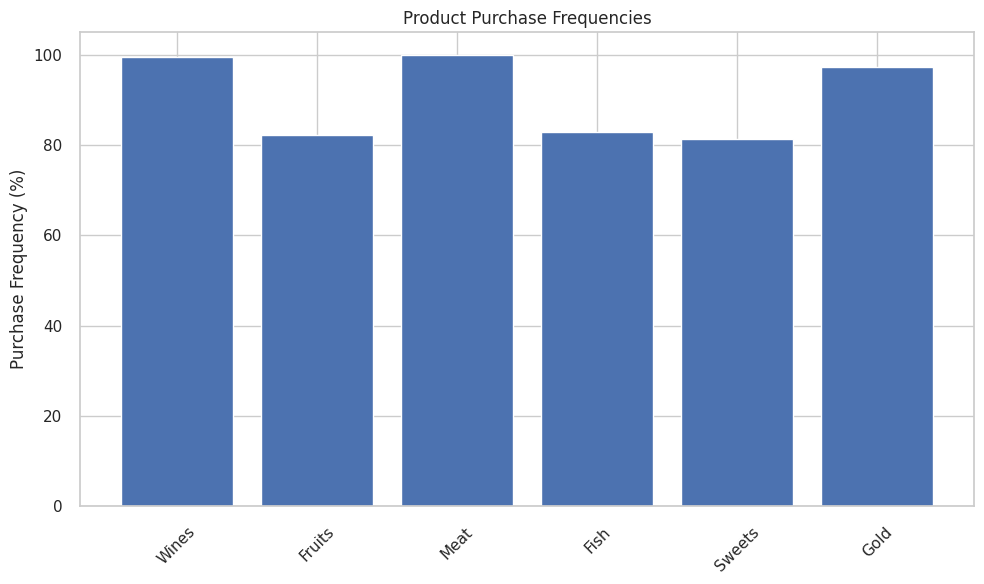

In [39]:
# Additional code to visualize key metrics:
import matplotlib.pyplot as plt

# Plotting purchase frequencies
plt.figure(figsize=(10, 6))
plt.bar(purchase_freq.index, purchase_freq.values)
plt.title('Product Purchase Frequencies')
plt.xticks(rotation=45)
plt.ylabel('Purchase Frequency (%)')
plt.savefig('market.png', format='png', dpi=300)
plt.tight_layout()
plt.show()

<a id="9"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">CONCLUSION</p>

In this project, We performed unsupervised clustering.
We did use dimensionality reduction followed by agglomerative clustering.
We came up with 4 clusters and further used them in profiling customers in clusters according to their family structures and income/spending.
Furthure, we did Association Mining Rule for all products
This can be used in planning better marketing strategies.


**<span style="color:#682F2F;"> Best Wishes!</span>**

<a id="10"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">END</p>